# Lab 2a Word Embeddings with GLoVe

Created by Tomas Nordström, Umeå University

Adapted by Jacob Farnsworth for HT 2025 Programmering för tekniska tillämpningar, NTI Gymnasiet Karlstad

## Write your name here.

## Background: Word Embeddings

As we've learned, machine learning models operate with numeric data. In the previous lab on image classification, the *input* to the model was *color data* (1 channel, 28x28 pixels) and the *output* was a *probability vector* (N different clothing categories, one-hot encoding).

How is it possible, then, to build machine learning models which operate on text, consisting of sentences, words and letters?

The simple answer is that language must be converted into a form the model can understand, aka numeric data. To do this, we usually use an *embedding model*. An embedding model converts words or even concepts into vectors.

With an embedding model, each word becomes a set of coordinates in an N-dimensional space, called the *embedding space*.

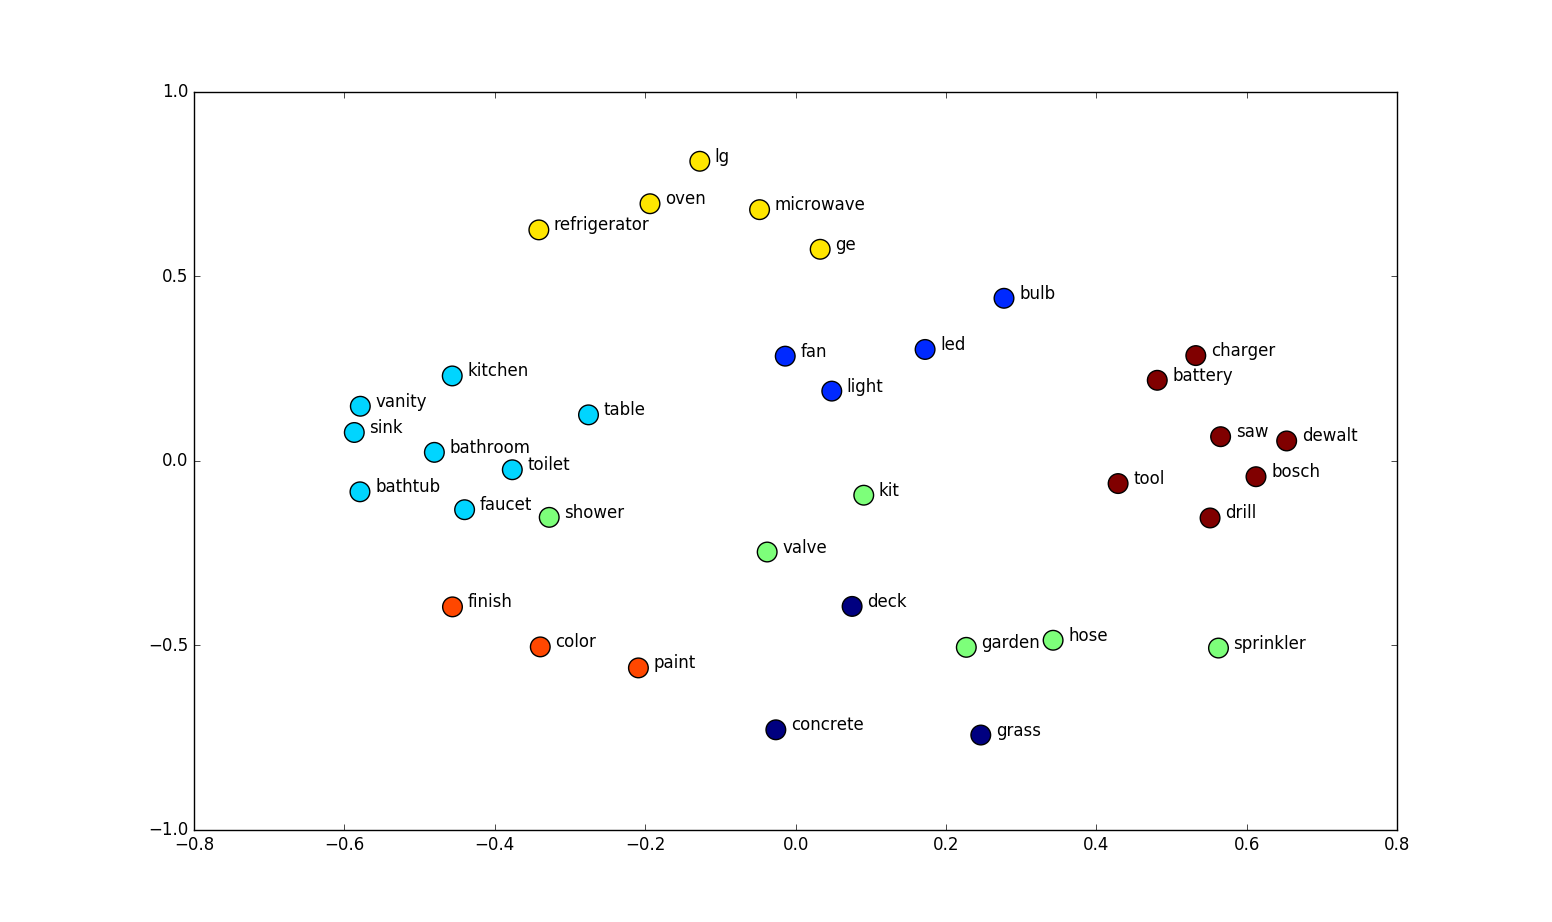

Words which are more closely related (and which are more likely to appear closer together) are physically close together in the embedding space.

For example: Look at the words "color" and "paint" in the example diagram. "color" (-0.34, -0.5) is fairly close to "paint" (-0.21, -0.54), because these words are closely related.

However, "battery" (0.47, 0.24) is quite far away from these two words, because it is mostly unrelated to them.

This was a very simplified example, showing an embedding space of only two dimensions. Real embedding models can have hundreds, even 1000+ dimensions, allowing them to capture a great variety of ways that words can be related.

In this lab, we will explore using an embedding model to transform words into vectors, and see how the embedding captures the concept of similarity by measuring the "closeness" of word vectors.

## Initialization

In [ ]:
import sys
import os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Helper libraries
import time
import numpy as np

import urllib
from zipfile import ZipFile

In [ ]:
# https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve#53643011
import progressbar
class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

## Word2vec class (replacing gensim)

In [ ]:
class MyProgressBar:
    def __call__(self, block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(downloaded / total_size, 1.0) * 100
        print(f"\rDownloading: {percent:.2f}%", end='')

# A minimal implementation of the most important gensim functionality
class W2V:
    def __init__(self):
        self.embeddings_index = {} # Dictionary mapping words to their embedding vectors
        self.word_to_index = {} # Mapping from word to index (for reverse lookup)
        self.index_to_word = [] # List of words in order of appearance (used for reverse lookup)
        self.embeddings_matrix = None # Matrix of all word vectors (rows correspond to words)
        self.normalize = False # Whether vectors were normalized to unit length

    def load_word2vec(self, path_to_glove_file, normalize=False):
        """
        Load GloVe vectors from a .txt file and populate internal data structures.
        Optionally normalize vectors to unit length for cosine similarity.
        """
        print(f"Loading GloVe vectors from {path_to_glove_file}...")
        self.normalize = normalize
        with open(path_to_glove_file, encoding="utf8") as f:
            for idx, line in enumerate(f):
                word, *vector = line.strip().split()
                coefs = np.asarray(vector, dtype="float32")
                if normalize:
                    norm = np.linalg.norm(coefs)
                    if norm > 0:
                        coefs = coefs / norm
                self.embeddings_index[word] = coefs
                self.word_to_index[word] = idx
                self.index_to_word.append(word)
        # Stack vectors into a matrix for fast dot product search
        self.embeddings_matrix = np.stack(list(self.embeddings_index.values()))
        print(f"Loaded {len(self.embeddings_index)} word vectors (normalized={normalize}).")
        return self

    def most_similar(self, positive=[], negative=[], topn=10):
        """
        Find top-N words most similar to a combination of positive and negative words.
        Accepts strings or lists for positive/negative.
        Raises KeyError if any input word is not in the vocabulary.
        """
        # Auto-wrap single words
        if isinstance(positive, str):
            positive = [positive]
        if isinstance(negative, str):
            negative = [negative]

        if not positive:
            raise ValueError("positive argument must be non-empty")

        # Validate words
        for word in positive + negative:
            if word not in self.embeddings_index:
                raise KeyError(f"The word '{word}' is not in the vocabulary.")

        # Create a mean vector by summing positive and subtracting negative vectors
        mean_vector = np.zeros_like(next(iter(self.embeddings_index.values())))
        for word in positive:
            mean_vector += self.embeddings_index[word]
        for word in negative:
            mean_vector -= self.embeddings_index[word]
        mean_vector /= (len(positive) + len(negative))

        # Normalize vectors if not already normalized
        if not self.normalize:
            norms = np.linalg.norm(self.embeddings_matrix, axis=1, keepdims=True)
            normalized_embeddings = self.embeddings_matrix / norms
            mean_norm = mean_vector / np.linalg.norm(mean_vector)
        else:
            normalized_embeddings = self.embeddings_matrix
            mean_norm = mean_vector / np.linalg.norm(mean_vector)

        # Compute cosine similarities between mean vector and all word vectors
        similarities = np.dot(normalized_embeddings, mean_norm)

        # Get top matches (excluding any input words)
        best_indices = np.argsort(-similarities)[:topn + len(positive) + len(negative)]
        results = []
        for idx in best_indices:
            word = self.index_to_word[idx]
            if word not in positive + negative:
                results.append((word, float(similarities[idx])))
            if len(results) == topn:
                break
        return results

    def key_to_index(self, word):
        """
        Return the integer index of a word in the vocabulary.
        Raises a KeyError if the word is not found.
        """
        if word in self.word_to_index:
            return self.word_to_index[word]
        else:
            raise KeyError(f"The word '{word}' is not in the vocabulary.")

    def similarity(self, word1, word2):
        """
        Return the cosine similarity between two words.
        Raises KeyError if either word is not in the vocabulary.
        """
        if word1 not in self.embeddings_index:
            raise KeyError(f"The word '{word1}' is not in the vocabulary.")
        if word2 not in self.embeddings_index:
            raise KeyError(f"The word '{word2}' is not in the vocabulary.")
        vec1 = self.embeddings_index[word1]
        vec2 = self.embeddings_index[word2]
        return -1 # Skipped here as this is part of the exercise

    def contains(self, word):
        """
        Check if a word exists in the vocabulary.
        Returns True or False.
        """
        return word in self.embeddings_index

    def __getitem__(self, word):
        """
        Returns the embedding vector for a given word.
        Raises KeyError if word is not in the vocabulary.
        """
        if word in self.embeddings_index:
            return self.embeddings_index[word]
        else:
            raise KeyError(f"The word '{word}' is not in the vocabulary.")

## Download word2vec models

In [ ]:
# For now we have only implemented the use of Glove word2vec archive.
model_to_use            = 'Glove'

### Using GloVe

Let's download pre-trained GloVe embeddings (a 822 MB zip file).

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100-D ones.



In [ ]:
# Download a file to kerasdata, but first check if it already exist, now with progress bar
DOWNLOADS_DIR = './kerasdata'
os.makedirs(DOWNLOADS_DIR, exist_ok=True) # create dir if not exist

if model_to_use == 'Glove':
  url= 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
  # Split on the rightmost / and take everything on the right side of that; up until '?'
  name = url.rsplit('/', 1)[-1].split('?', 1)[0]
  filename = os.path.join(DOWNLOADS_DIR, name)

  # Download the file if it does not exist
  if not os.path.isfile(filename):
    print(f'Retrieving url: {url}', flush=True)
    urllib.request.urlretrieve(url, filename, reporthook=MyProgressBar())
  else:
    print(f'Using local zip file: {filename}')

  GLOVEDIR = os.path.join(DOWNLOADS_DIR, 'Glove')
  path_to_glove_file =  os.path.join(GLOVEDIR, 'glove.6B.100d.txt')
  if not os.path.isfile(path_to_glove_file):
    ZipFile(filename).extractall(GLOVEDIR)

  print(f'Using local glove file: {path_to_glove_file}')

Using local zip file: ./kerasdata/glove.6B.zip
Using local glove file: ./kerasdata/Glove/glove.6B.100d.txt


In [ ]:
print(f'Using local glove file: {path_to_glove_file}')
w2v = W2V().load_word2vec(path_to_glove_file)

Using local glove file: ./kerasdata/Glove/glove.6B.100d.txt
Loading GloVe vectors from ./kerasdata/Glove/glove.6B.100d.txt...
Loaded 400000 word vectors (normalized=False).


## Experiments

In [ ]:
# First check out the word2vec model
print(f'Model name {model_to_use}')
print(f'Total number of words: {len(w2v.word_to_index)}')
print(f'Some example words: {list(w2v.word_to_index)[:20]}')

first_word = next(iter(w2v.word_to_index))
print(f'First word: {first_word}')
embedding_len = len(w2v[first_word])
print(f'Embedding vector length: {embedding_len}')

# Then check out a vector
word1 = "cat"
print(f'\nLooking at "{word1}"')
cat_vector = w2v[word1]
print(f'Vector: {cat_vector[:10]}...')

Model name Glove
Total number of words: 400000
Some example words: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
First word: the
Embedding vector length: 100

Looking at "cat"
Vector: [ 0.23088   0.28283   0.6318   -0.59411  -0.58599   0.63255   0.24402
 -0.14108   0.060815 -0.7898  ]...


### Similarity

Now we want to find similarity between word vectors and need to define a [similarity measure](https://en.wikipedia.org/wiki/Similarity_measure). In this exercise we will use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) as a similarity measure.

Your task is now to define a similarity function, and then generate three word vectors for “cat”, “cut”, and “dog” and compare the similarity between them using your similarity function.


### STUDENTSVAR (Kod):

In [ ]:
def similarity(vec1,vec2):
##################### TODO: YOUR CODE STARTS HERE #####################
    cosine_dist = -42
    return cosine_dist
##################### TODO: YOUR CODE ENDS HERE #######################

In [ ]:
cut_vector = w2v["cut"]
dog_vector = w2v["dog"]

##################### TODO: YOUR CODE STARTS HERE #####################
# Compare the similarity between "cat”, “cut”, and “dog”


##################### TODO: YOUR CODE ENDS HERE #######################

## Further experiments

Now, your task is to compare similarity between more words. You will compare **at least 10 words** of your choice in addition to "cat", "cut", and "dog".

Try to experiment with words which can be related in *different ways*.

For example: "cat" and "dog" are both types of pet animals. What about words related to pets, but which aren't names of animals? (Words related to treats, pet care, etc) What about names of animals which aren't typically kept as pets?

You can also try words that have different grammatical roles. For example, "cat", "cut" and "dog" act as nouns, what happens if you try verbs, adjectives, adverbs?

Try also some words which are different "intensities" of the same idea. For example, "hot" and "warm". Is there any pattern with cosine similarity of these kinds of words?

### STUDENTSVAR (Kod):

In [ ]:
##################### TODO: YOUR CODE STARTS HERE #####################
# Create more examples


##################### TODO: YOUR CODE ENDS HERE #######################

### STUDENTSVAR (Analys av exempel):

## Finding most similar
We are also interested in finding the n closest words to a certain vector.

We do this by calculating a similarity to all vectors in the word2vec dictionary/matrix and then sort according to similarity score and take the top n-values.

To get the ten most similar words to computer we do:
`sims = w2v.most_similar('computer', topn=10)`

We sometimes want to do operations with the vectors to do “king”-”man”+”woman”, and to support that we can use the two parameters: positive and negative:
`w2v.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)`


In [ ]:
# Find similar words
sims = w2v.most_similar('computer', topn=10)
print(sims)

# Classic example
result = w2v.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('computers', 0.8751983642578125), ('software', 0.8373122215270996), ('technology', 0.7642159461975098), ('pc', 0.7366448640823364), ('hardware', 0.7290390729904175), ('internet', 0.7286775708198547), ('desktop', 0.7234442234039307), ('electronic', 0.7221828699111938), ('systems', 0.7197922468185425), ('computing', 0.7141730785369873)]
[('queen', 0.7834413051605225)]


### STUDENTSVAR (Kod):
Skapa fler "räkneexempel" och analysera dina resultat

In [ ]:
##################### TODO: YOUR CODE STARTS HERE #####################
# Create more examples


##################### TODO: YOUR CODE ENDS HERE #######################

### STUDENTSVAR (Analys av räkneexempel):
    


## (VG) Methods for Measuring Similarity

In this exercise, we used cosine similarity to compare different word vectors. However, cosine similarity is not the only way of measuring similarity between word vectors.

Another method is to look at the Euclidean distance between vectors. In your math classes, you've probably learned that you can measure the distance between 2D points with the formula

$d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$

In 3D, the formula becomes

$d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

Do you see a pattern? For higher dimensions (even hundreds or thousands of dimensions) the formula can be extended by adding more terms inside the square root.

Say we have vectors $v_1$ and $v_2$, of any dimension (as long as the dimensions match). We can express the distance as:

$d = ||v_1 - v_2||$

$||$ is sometimes called the "norm" of a vector. Norm simply means the distance from the origin.

For this part of the lab, your task is to do the following:

1. Implement `similarity_distance` which computes the Euclidean distance between two points. (A good idea is to look up online how to compute the norm in numpy)
2. Compare the words you chose in the earlier exercises (starting with cat, dog, cut) using Euclidean distance. Record your results carefully.
3. Analyze your results. How does the measure of Euclidean distance compare with cosine similarity? When words are similar via Euclidean distance, are those same words also similar via cosine similarity, or vice versa? Does there seem to be any advantage, or disadvantage of using cosine similarity or Euclidean distance?

For your analysis, **pay close attention** to what happens when words are related in different ways:

-    Mostly unrelated words, e.g. "dog" and "cut"
-    Words that belong to the same type or category of something
-    Words that are different "intensities" of the same idea

### STUDENTSVAR (Kod):

In [ ]:
def similarity_distance(vec1,vec2):
##################### TODO: YOUR CODE STARTS HERE #####################
    distance = -42
    return distance
##################### TODO: YOUR CODE ENDS HERE #######################

In [ ]:
cut_vector = w2v["cut"]
dog_vector = w2v["dog"]

##################### TODO: YOUR CODE STARTS HERE #####################
# Compare the Euclidean distance between "cat”, “cut”, “dog”, and the other
# words you chose in the previous exercises


##################### TODO: YOUR CODE ENDS HERE #######################

### STUDENTSVAR (Analys):

-    

# AI Deklaration
Användning av Al-verktyg är tillåtet i begränsad utsträckning. Du får inte klistra in uppgifter eller delar av uppgifter, men du får använda AI för att förtydliga nya ord och begrepp eller ge exempel.

Här på slutet ska du ange allmänt vilka AI-verktyg som använts, hur du använt dem, och hur användbara dessa verktyg är. Om du inte använt AI-stöd så skriv bara att "AI-verktyg har ej använts".

### STUDENTSVAR (AI-användning):